In [23]:
import sys
import os

# If your notebook is in the same directory as the 'data_collector' module, you can use:
# root_path = os.getcwd()

# If you need to go up one directory from the notebook's location, you can use:
root_path = os.path.dirname(os.getcwd())

sys.path.append(root_path)

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns

from data_collection.data_collector import DataCollector


In [12]:
dc = DataCollector('serie_a')
df = dc.collect_data(year_start=2010, year_end=2023, write_csv=False)
# sample output

df.head()

Fetching data: 100%|█████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]
/Users/admin/git_projects/football/data_collection/data_collector.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Date=lambda x: pd.to_datetime(x['Date'], dayfirst=True),


,game_id,Div,Date,HomeTeam,AwayTeam,TG,FTHG,FTAG,FTR,HTHG,...,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,city_name,lat,lon
0,2360c489,serie_a,2010-08-28,Roma,Cesena,0.0,0.0,0.0,D,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2010/2011,Roma,41.893320,12.482932
1,c80e8d22,serie_a,2010-08-28,Udinese,Genoa,1.0,0.0,1.0,A,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2010/2011,Udine,46.063463,13.235838
2,d4ed0ea8,serie_a,2010-08-29,Bari,Juventus,1.0,1.0,0.0,H,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2010/2011,Bari,41.125784,16.862029
3,43d31ae3,serie_a,2010-08-29,Chievo,Catania,3.0,2.0,1.0,H,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2010/2011,Verona,45.438496,10.992412
4,080c5696,serie_a,2010-08-29,Fiorentina,Napoli,2.0,1.0,1.0,D,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2010/2011,Firenze,43.769871,11.255576


# Summary Metrics by Team

In [10]:
teams_stats = dc.compute_team_statistics(df, 2003, 2023)
teams_stats.sort_values('WinRatio', ascending=False)


,HomeTeam,HomeGames,HomeWins,HomeDraws,HomeGoals,AwayGames,AwayWins,AwayDraws,AwayGoals,TotalGames,TotalWins,TotalDraws,TotalGoals,WinRatio,DrawRatio,HomeWinRatio,AwayWinRatio,HomeGoalRatio,AwayGoalRatio,TotalGoalRatio
19,Juventus,341,252,58,713.0,340,193,81,554.0,681,445,139,1267.0,0.653451,0.204112,0.739003,0.567647,2.090909,1.629412,1.860499
18,Inter,340,219,72,679.0,339,158,88,525.0,679,377,160,1204.0,0.555228,0.235641,0.644118,0.466077,1.997059,1.548673,1.773196
27,Napoli,294,185,66,595.0,294,138,65,470.0,588,323,131,1065.0,0.549320,0.222789,0.629252,0.469388,2.023810,1.598639,1.811224
24,Milan,338,207,75,619.0,338,155,91,527.0,676,362,166,1146.0,0.535503,0.245562,0.612426,0.458580,1.831361,1.559172,1.695266
34,Roma,337,213,70,679.0,338,145,91,513.0,675,358,161,1192.0,0.530370,0.238519,0.632047,0.428994,2.014837,1.517751,1.765926
20,Lazio,338,183,75,589.0,341,128,80,453.0,679,311,155,1042.0,0.458027,0.228277,0.541420,0.375367,1.742604,1.328446,1.534610
15,Fiorentina,328,164,90,525.0,329,104,93,416.0,657,268,183,941.0,0.407915,0.278539,0.500000,0.316109,1.600610,1.264438,1.432268
2,Atalanta,290,139,72,473.0,288,88,77,362.0,578,227,149,835.0,0.392734,0.257785,0.479310,0.305556,1.631034,1.256944,1.444637
43,Udinese,337,139,95,465.0,337,92,83,383.0,674,231,178,848.0,0.342730,0.264095,0.412463,0.272997,1.379822,1.136499,1.258160
26,Monza,28,10,9,35.0,28,9,8,29.0,56,19,17,64.0,0.339286,0.303571,0.357143,0.321429,1.250000,1.035714,1.142857


## Distributions

In [4]:
df.head()

,game_id,Div,Date,HomeTeam,AwayTeam,TG,FTHG,FTAG,FTR,HTHG,...,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,city_name,lat,lon
0,04bd7280,serie_a,2003-08-30,Reggina,Sampdoria,4.0,2.0,2.0,D,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Reggio Calabria,38.103539,15.639756
1,b7a5535f,serie_a,2003-08-31,Bologna,Parma,4.0,2.0,2.0,D,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Bologna,44.493820,11.342633
2,33dce6ef,serie_a,2003-08-31,Brescia,Chievo,2.0,1.0,1.0,D,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Brescia,45.779580,10.425873
3,bef57e82,serie_a,2003-08-31,Inter,Modena,2.0,2.0,0.0,H,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Milano,45.464194,9.189635
4,a0cfeb7d,serie_a,2003-08-31,Juventus,Empoli,6.0,5.0,1.0,H,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2003/2004,Torino,45.067755,7.682489


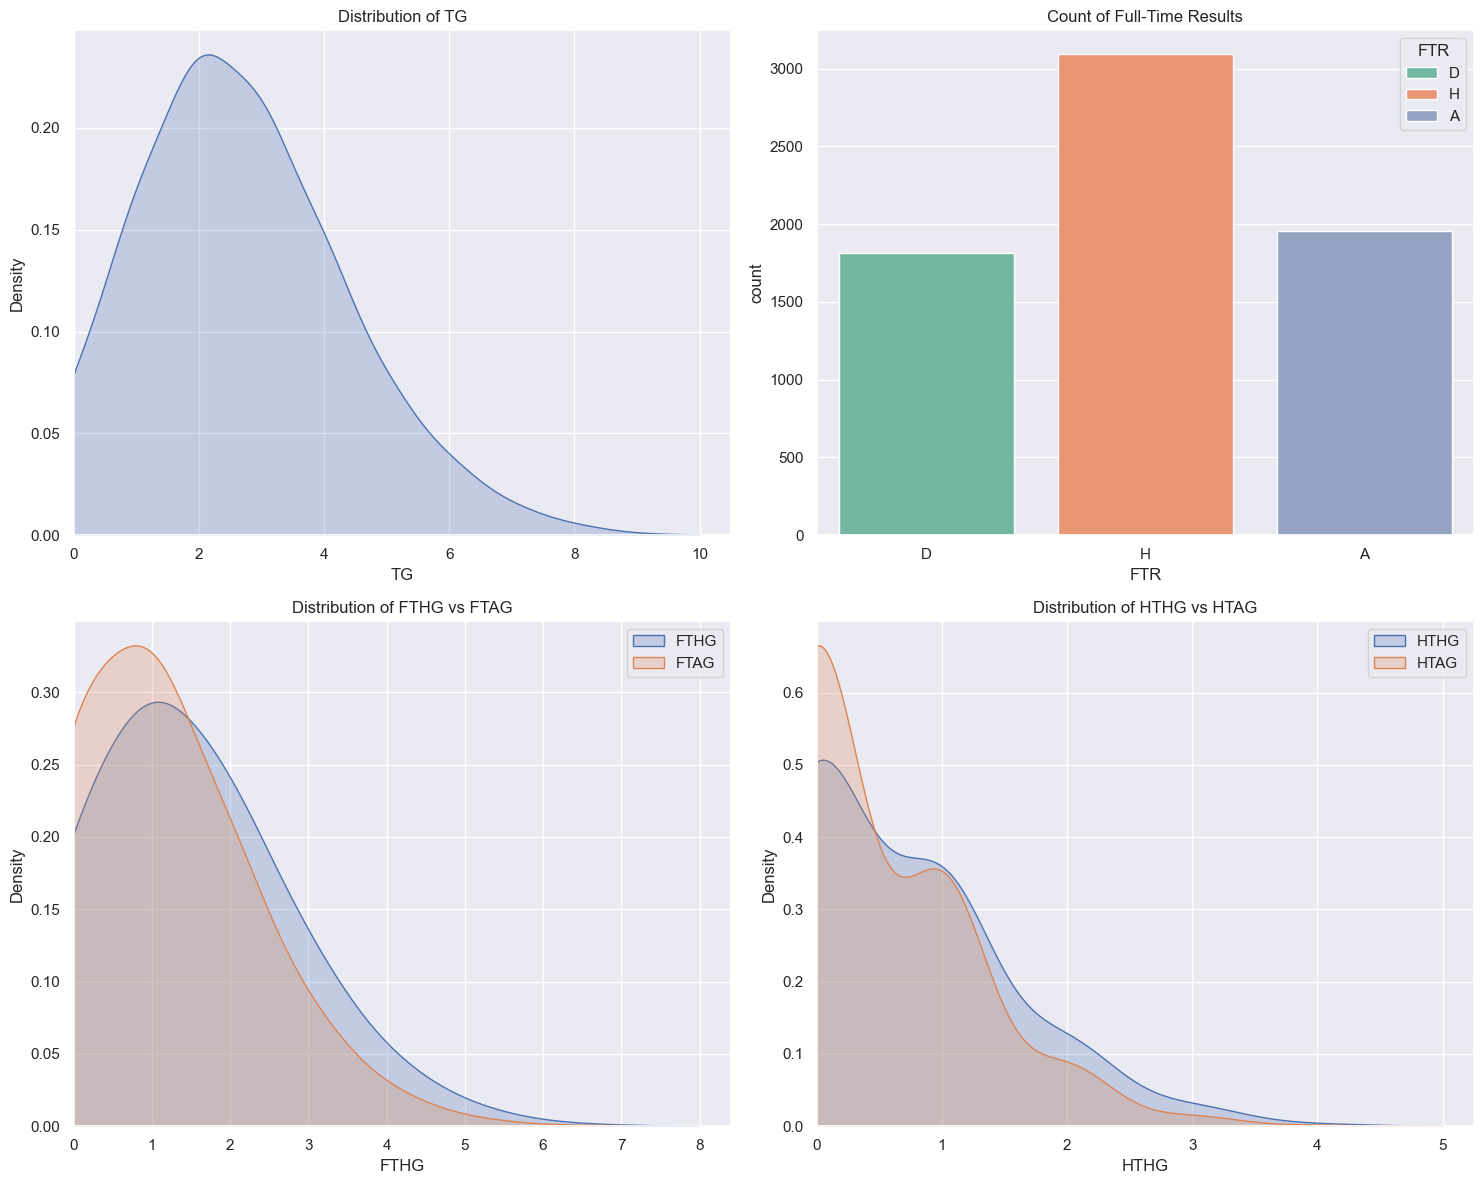

In [5]:
sns.set_theme()

f, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjusted figsize for better visibility

# KDE plot for 'TG'
sns.kdeplot(data=df, x='TG', cut=0, bw_adjust=2, ax=axes[0, 0], fill=True)
axes[0, 0].set_xlim(left=0)
axes[0, 0].set_title('Distribution of TG')

# Count plot for 'FTR'
sns.countplot(data=df, x='FTR', hue='FTR', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Count of Full-Time Results')


sns.kdeplot(data=df, x='FTHG', ax=axes[1, 0], cut=0, bw_adjust=3, fill=True, label='FTHG')
sns.kdeplot(data=df, x='FTAG', ax=axes[1, 0], cut=0, bw_adjust=3, fill=True, label='FTAG')
axes[1, 0].set_xlim(left=0)
axes[1, 0].set_title('Distribution of FTHG vs FTAG')
axes[1, 0].legend()

sns.kdeplot(data=df, x='HTHG', ax=axes[1, 1], cut=0, bw_adjust=3, fill=True, label='HTHG')
sns.kdeplot(data=df, x='HTAG', ax=axes[1, 1], cut=0, bw_adjust=3, fill=True, label='HTAG')
axes[1, 1].set_xlim(left=0)
axes[1, 1].set_title('Distribution of HTHG vs HTAG')
axes[1, 1].legend()


# You can add another plot in axes[1, 1] as needed

plt.tight_layout()
plt.show()

<Axes: xlabel='HomeTeam', ylabel='TG'>

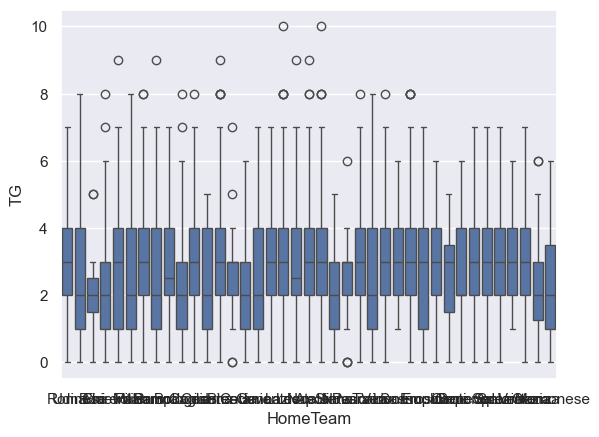

In [14]:
sns.boxplot(x=df['HomeTeam'], y=df['TG'])

## Weather Data

In [6]:
weather = pd.read_csv("/Users/admin/git_projects/football/data_collection/weather_test.csv")
weather.head()

/var/folders/cz/tsrtpglj4x3fc4dskw2pnjrc0000gn/T/ipykernel_56322/2066723148.py:1: DtypeWarning: Columns (49,95) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv("/Users/admin/git_projects/football/data_collection/weather_test.csv")


,game_id,Div,Date,HomeTeam,TG,AwayTeam,FTHG,FTAG,FTR,HTHG,...,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover,solarradiation,conditions
0,9756db2e,serie_a,2003-08-30,Reggina,4.0,Sampdoria,2.0,2.0,D,2.0,...,37.49,21.1,0.0,29.5,360.0,1012.9,10.0,NaN,NaN,Clear
1,e4604038,serie_a,2003-08-31,Bologna,4.0,Parma,2.0,2.0,D,1.0,...,22.71,8.1,0.0,31.3,230.0,1007.1,11.0,50.2,NaN,Partially cloudy
2,e4be3e26,serie_a,2003-08-31,Brescia,2.0,Chievo,1.0,1.0,D,0.0,...,29.58,9.6,0.0,12.4,248.0,1007.1,11.0,49.6,NaN,Partially cloudy
3,22af961b,serie_a,2003-08-31,Inter,2.0,Modena,2.0,0.0,H,0.0,...,29.70,11.0,0.0,24.9,326.0,1007.2,11.0,30.5,NaN,Partially cloudy
4,e6bf6b52,serie_a,2003-08-31,Juventus,6.0,Empoli,5.0,1.0,H,1.0,...,24.55,2.1,0.0,14.1,354.0,1010.2,10.1,30.0,NaN,Partially cloudy


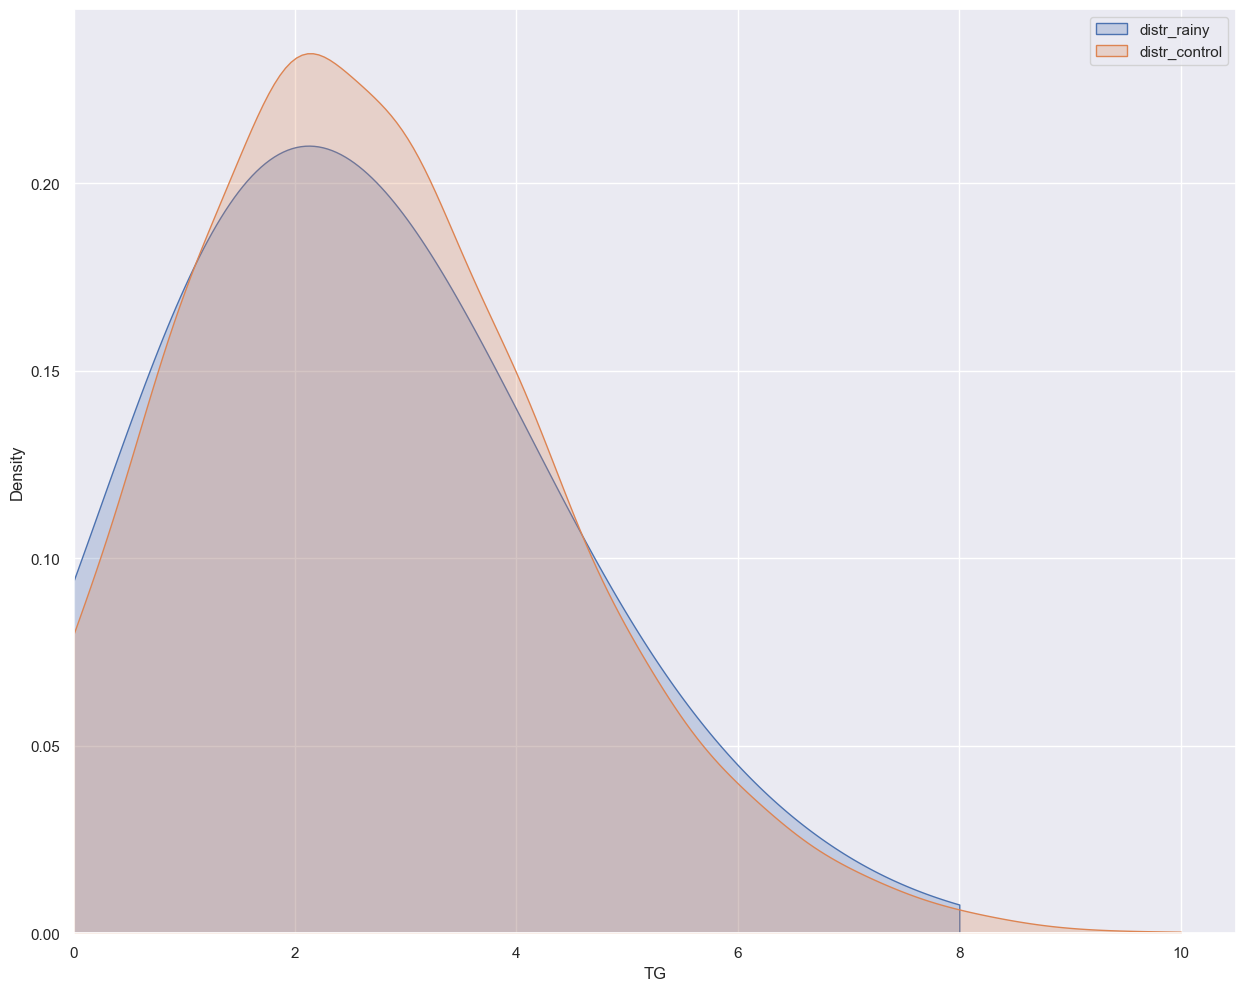

In [7]:
f, ax = plt.subplots(1, 1, figsize=(15, 12)) 

sns.kdeplot(data=weather.query("precip > 0.5"), x='TG', cut=0, bw_adjust=2, ax=ax, fill=True, label='distr_rainy')
sns.kdeplot(data=weather, x='TG', cut=0, bw_adjust=2, ax=ax, fill=True, label='distr_control')
ax.set_xlim(left=0)
ax.legend()




In [8]:
# Linear Regression of TG on weather components
weather_mdl = weather.dropna(subset=['temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed',
       'winddir', 'pressure', 'visibility', 'cloudcover'])
x = weather_mdl.iloc[:, 157:-2]
y = weather_mdl.iloc[:, 4]

model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     TG   R-squared (uncentered):                   0.724
Model:                            OLS   Adj. R-squared (uncentered):              0.724
Method:                 Least Squares   F-statistic:                              1902.
Date:                Tue, 19 Mar 2024   Prob (F-statistic):                        0.00
Time:                        15:36:00   Log-Likelihood:                         -13969.
No. Observations:                7250   AIC:                                  2.796e+04
Df Residuals:                    7240   BIC:                                  2.803e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0462      0.029      1.569      0.117      -0.012       0.104
feelslike     -0.0269      0.024     -1.142      0.254      -0.073       0.019
humidity       0.0051      0.005      1.062      0.288      -0.004       0.014
dew           -0.0051      0.018     -0.282      0.778      -0.041       0.031
precip        -0.0151      0.010     -1.468      0.142      -0.035       0.005
windspeed     -0.0019      0.003     -0.742      0.458      -0.007       0.003
winddir        0.0002      0.000      0.834      0.404      -0.000       0.001
pressure       0.0021      0.000      5.050      0.000       0.001       0.003
visibility    -0.0031      0.003     -0.932      0.351      -0.010       0.003
cloudcover    -0.0007      0.001     -0.871      0.384      -0.002       0.001
==============================================================================
Omnibus:                      368.022   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              424.850
Skew:                           0.581   Prob(JB):                     5.56e-93
Kurtosis:                       3.234   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Means

In [29]:
features = ['TG','FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR','temp','humidity', 'precip', 'windspeed']
scaler = StandardScaler()

clust = weather[features].dropna()
scaler.fit(clust)
clust_scaled = scaler.fit_transform(clust)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(clust_scaled)
clust['cluster'] = clusters

In [30]:
clust

,TG,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,temp,humidity,precip,windspeed,cluster
494,3.0,2.0,1.0,15.0,9.0,9.0,4.0,18.0,23.0,9.0,3.0,1.0,4.0,0.0,0.0,28.7,40.79,0.000,5.3,1
495,3.0,2.0,1.0,17.0,6.0,7.0,5.0,27.0,21.0,9.0,2.0,2.0,3.0,0.0,0.0,27.6,44.79,0.000,3.9,2
496,2.0,1.0,1.0,8.0,16.0,3.0,9.0,22.0,16.0,0.0,5.0,2.0,1.0,0.0,0.0,25.0,47.52,0.000,13.1,4
497,3.0,3.0,0.0,16.0,7.0,9.0,3.0,13.0,20.0,6.0,1.0,1.0,3.0,0.0,0.0,21.5,77.28,0.000,4.4,1
498,1.0,1.0,0.0,16.0,2.0,7.0,0.0,16.0,12.0,6.0,2.0,1.0,2.0,0.0,0.0,22.8,54.70,0.000,4.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7486,1.0,0.0,1.0,15.0,13.0,3.0,4.0,15.0,19.0,11.0,6.0,3.0,3.0,0.0,1.0,16.1,77.29,0.008,38.1,2
7487,1.0,1.0,0.0,15.0,5.0,5.0,2.0,18.0,13.0,11.0,4.0,1.0,4.0,0.0,0.0,7.8,93.06,22.713,16.7,2
7488,4.0,2.0,2.0,18.0,7.0,5.0,3.0,12.0,10.0,4.0,3.0,0.0,1.0,0.0,0.0,4.9,97.43,11.622,11.1,1
7489,4.0,2.0,2.0,15.0,10.0,5.0,5.0,10.0,15.0,8.0,2.0,2.0,5.0,0.0,0.0,10.0,87.37,6.024,35.2,0


Text(0, 0.5, 'Full-Time Goals (TG)')

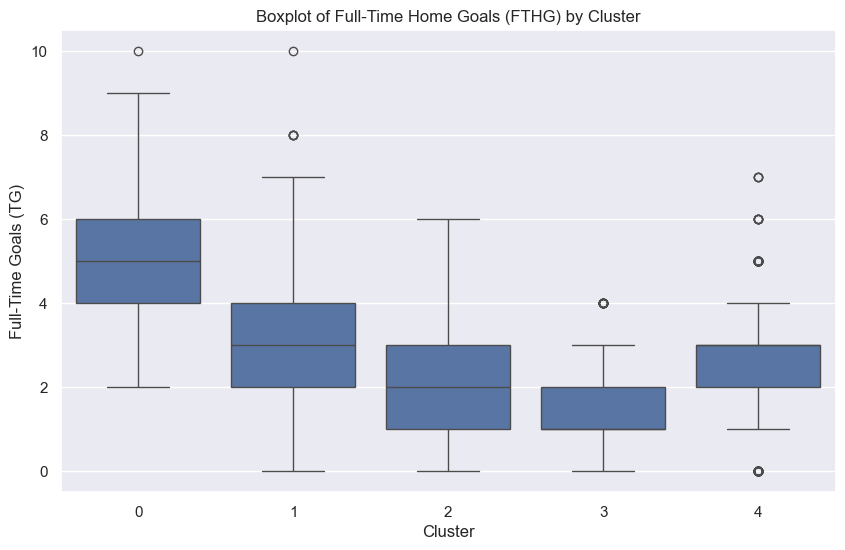

In [37]:
clust_means = (
    clust.groupby('cluster')
    .mean()
)

clust_medians = (
    clust.groupby('cluster')
    .median()
)

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='TG', data=clust)
plt.title('Boxplot of Full-Time Home Goals (FTHG) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Full-Time Goals (TG)')

In [43]:
clust_medians

,TG,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,temp,humidity,precip,windspeed
cluster,,,,,,,,,,,,,,,,,,,
0,5.0,2.0,2.0,14.0,13.0,6.0,6.0,14.0,15.0,5.0,4.0,2.0,2.0,0.0,0.0,16.90,60.380,0.0,9.4
1,3.0,2.0,1.0,19.0,8.0,8.0,3.0,13.0,13.0,8.0,3.0,1.0,2.0,0.0,0.0,14.90,64.320,0.0,8.5
2,2.0,1.0,1.0,13.0,9.0,5.0,3.0,19.0,19.0,5.0,4.0,3.0,3.0,0.0,0.0,13.80,65.570,0.0,9.3
3,1.0,1.0,0.0,12.0,10.0,4.0,3.0,14.0,14.0,5.0,4.0,2.0,2.0,0.0,0.0,16.80,59.750,0.0,9.3
4,3.0,1.0,1.0,9.0,16.0,3.0,6.0,14.0,14.0,4.0,7.0,2.0,2.0,0.0,0.0,14.45,67.405,0.0,10.8
